## Topic Modelling (joint plots by quality band)

Shorter notebook just for Figures 9 and 10 in the paper.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random
from tqdm import tqdm
import pandas as pd
import numpy as np

seed = 43
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import seaborn as sns
sns.set(style="white")

### Load the dataset

Created with the main Topic Modelling notebook.

In [4]:
bands_data = {x:dict() for x in range(1,5)}

In [5]:
import pickle, os

for band in range(1,5):
    with open("trove_overproof/models/hum_band_%d.pkl"%band, 'rb') as handle:
        bands_data[band]["model_human"] = pickle.load(handle)
    with open("trove_overproof/models/corpus_hum_band_%d.pkl"%band, 'rb') as handle:
        bands_data[band]["corpus_human"] = pickle.load(handle)
    with open("trove_overproof/models/dictionary_hum_band_%d.pkl"%band, 'rb') as handle:
        bands_data[band]["dictionary_human"] = pickle.load(handle)
    with open("trove_overproof/models/ocr_band_%d.pkl"%band, 'rb') as handle:
        bands_data[band]["model_ocr"] = pickle.load(handle)
    with open("trove_overproof/models/corpus_ocr_band_%d.pkl"%band, 'rb') as handle:
        bands_data[band]["corpus_ocr"] = pickle.load(handle)
    with open("trove_overproof/models/dictionary_ocr_band_%d.pkl"%band, 'rb') as handle:
        bands_data[band]["dictionary_ocr"] = pickle.load(handle)

### Evaluation

#### Intrinsic eval

See http://qpleple.com/topic-coherence-to-evaluate-topic-models.

In [7]:
for band in range(1,5):
    
    print("Quality band",band)
    # Human
    # Compute Perplexity
    print('\nPerplexity (Human): ', bands_data[band]["model_human"].log_perplexity(bands_data[band]["corpus_human"]))  # a measure of how good the model is. The lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=bands_data[band]["model_human"], corpus=bands_data[band]["corpus_human"], dictionary=bands_data[band]["dictionary_human"], coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score (Human): ', coherence_lda)
    
    # OCR
    # Compute Perplexity
    print('\nPerplexity (OCR): ', bands_data[band]["model_ocr"].log_perplexity(bands_data[band]["corpus_ocr"]))  # a measure of how good the model is. The lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=bands_data[band]["model_ocr"], corpus=bands_data[band]["corpus_ocr"], dictionary=bands_data[band]["dictionary_ocr"], coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score (OCR): ', coherence_lda)
    print("==========\n")

Quality band 1

Perplexity (Human):  -8.103261158627364

Coherence Score (Human):  -1.636788533548382

Perplexity (OCR):  -8.602782438888957

Coherence Score (OCR):  -1.744833949213988

Quality band 2

Perplexity (Human):  -8.210335723784008

Coherence Score (Human):  -1.717423902243484

Perplexity (OCR):  -8.960456087224186

Coherence Score (OCR):  -1.8652779401051685

Quality band 3

Perplexity (Human):  -7.945579058932222

Coherence Score (Human):  -2.2853392147627445

Perplexity (OCR):  -8.57412651382853

Coherence Score (OCR):  -2.1544280903218933

Quality band 4

Perplexity (Human):  -7.610617401464275

Coherence Score (Human):  -2.6515871055832645

Perplexity (OCR):  -7.973356022098555

Coherence Score (OCR):  -2.8655108395602737



#### Match of topics

We match every topic in the OCR model with a topic in the human model (by best matching), and assess the overall distance between the two using the weighted total distance over a set of N top words (from the human model to the ocr model). The higher this value, the closest two topics are.

Note that to find a matching, we create a weighted network and find the maximal bipartite matching using NetworkX.

Afterwards, we can measure the distance of the best match, e.g., using the KL divergence (over the same set of words).

In [8]:
import networkx as nx
from scipy.stats import entropy
from collections import defaultdict

# analyse matches

distances = {x:list() for x in range(1,5)}
n_words_in_common = {x:list() for x in range(1,5)}
matches = {x:defaultdict(int) for x in range(1,5)}
top_n = 500

for band in range(1,5):
    
    G = nx.Graph()
    model_human = bands_data[band]["model_human"]
    model_ocr = bands_data[band]["model_ocr"]

    # add bipartite nodes
    G.add_nodes_from(['h_'+str(t_h[0]) for t_h in model_human.show_topics(num_topics = -1, formatted=False, num_words=1)], bipartite=0)
    G.add_nodes_from(['o_'+str(t_o[0]) for t_o in model_ocr.show_topics(num_topics = -1, formatted=False, num_words=1)], bipartite=1)

    # add weighted edges
    for t_h in model_human.show_topics(num_topics = -1, formatted=False, num_words=top_n):
        for t_o in model_ocr.show_topics(num_topics = -1, formatted=False, num_words=top_n):
            # note that the higher the weight, the shorter the distance between the two distributions, so we do 1-weight to then do minimal matching
            words_of_h = [x[0] for x in t_h[1]]
            words_of_o = [x[0] for x in t_o[1]]
            weights_of_o = {x[0]:x[1] for x in t_o[1]}
            words_in_common = list(set(words_of_h).intersection(set(words_of_o)))
            # sum the weighted joint probability of every shared word in the two models
            avg_weight = 1 - sum([x[1]*weights_of_o[x[0]] for x in t_h[1] if x[0] in words_in_common])
            G.add_edge('h_'+str(t_h[0]),'o_'+str(t_o[0]),weight=avg_weight)
            G.add_edge('o_'+str(t_o[0]),'h_'+str(t_h[0]),weight=avg_weight)
    
    bipartite_solution = nx.bipartite.matching.minimum_weight_full_matching(G)
    
    # calculate distances
    for match_h,match_o in bipartite_solution.items():
        if match_h.startswith('o'): # to avoid repeating the matches (complete graph!)
            break
        matches[band][int(match_h.split("_")[1])] = int(match_o.split("_")[1])
        m_h = model_human.show_topic(int(match_h.split("_")[1]), topn=top_n)
        m_o = model_ocr.show_topic(int(match_o.split("_")[1]), topn=top_n)
        weights_of_o = {x[0]:x[1] for x in m_o}
        words_of_h = [x[0] for x in m_h]
        words_of_o = [x[0] for x in m_o]
        words_in_common = list(set(words_of_h).intersection(set(words_of_o)))
        n_words_in_common[band].append(len(words_in_common)/top_n)
        dist_h = list()
        dist_o = list()
        for w in m_h:
            if w[0] in words_in_common:
                dist_h.append(w[1])
                dist_o.append(weights_of_o[w[0]])
        # normalize
        dist_h = dist_h/sum(dist_h)
        dist_o = dist_o/sum(dist_o)
        dist = entropy(dist_h,dist_o)
        distances[band].append(dist)

In [22]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

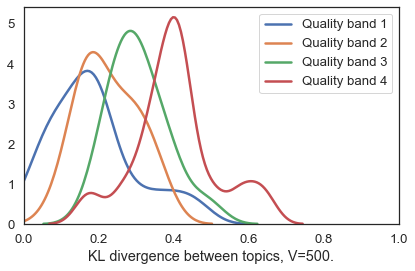

In [27]:
# Figure 9
for band in range(1,5):
    sns.distplot(distances[band], hist=False, label="Quality band %d"%band)
plt.xlim((0,1))
plt.xlabel("KL divergence between topics, V=%d."%top_n)
plt.tight_layout()
plt.savefig("figures/topic_modelling/KL_divergence_topics.pdf")

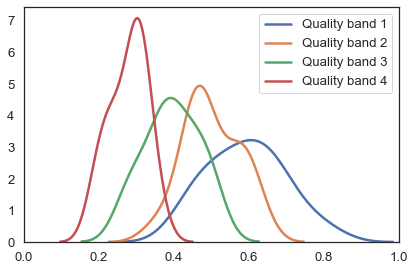

In [28]:
# Figure 10
for band in range(1,5):
    sns.distplot(n_words_in_common[band], hist=False, label="Quality band %d"%band)
plt.xlim((0,1))
plt.tight_layout()
plt.savefig("figures/topic_modelling/Words_in_common_topics.pdf")